In [45]:
!pip install torchmetrics

In [46]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

In [47]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.15, random_state=42)

In [49]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.len = self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [50]:
train_dataset = Data(x_train, y_train)
trainloader = DataLoader(dataset=train_dataset,batch_size=64)
val_dataset = Data(x_val, y_val)
val_loader = DataLoader(dataset=val_dataset,batch_size=64)
test_dataset = Data(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset,batch_size=64)

In [51]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

    def forward(self,x):
        x = x.type(torch.float32)
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x


In [52]:
input_dim = 4
hidden_dim = 25
output_dim = 3
model = Net(input_dim,hidden_dim,output_dim)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
model = Net(input_dim,hidden_dim,output_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [55]:
np.unique(Y)

array([0, 1, 2])

In [56]:
accuracy = Accuracy(task='multiclass', num_classes=3)
precision = Precision(task='multiclass', average='macro', num_classes=3)
recall = Recall(task='multiclass', average='macro', num_classes=3)
f1 = F1Score(task='multiclass', average='macro', num_classes=3)

In [57]:
num_epochs = 100

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# Training and Validation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for x, y in tqdm(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Training Metrics
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)
    train_acc = accuracy(all_preds, all_labels)
    train_precision = precision(all_preds, all_labels)
    train_recall = recall(all_preds, all_labels)
    train_f1 = f1(all_preds, all_labels)
    avg_train_loss = total_loss / len(trainloader)

    train_acc_list.append(train_acc)
    train_loss_list.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Train Acc: {train_acc:.4f} - "
          f"Train Precision: {train_precision:.4f} - "
          f"Train Recall: {train_recall:.4f} - "
          f"Train F1: {train_f1:.4f}")

    # Validation phase
    model.eval()
    val_total_loss = 0
    val_all_preds, val_all_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss = loss_fn(y_pred, y)

            val_total_loss += val_loss.item()
            val_all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
            val_all_labels.extend(y.cpu().numpy())

    # Validation Metrics
    val_all_preds = torch.tensor(val_all_preds)
    val_all_labels = torch.tensor(val_all_labels)
    val_acc = accuracy(val_all_preds, val_all_labels)
    val_precision = precision(val_all_preds, val_all_labels)
    val_recall = recall(val_all_preds, val_all_labels)
    val_f1 = f1(val_all_preds, val_all_labels)
    avg_val_loss = val_total_loss / len(val_loader)

    val_acc_list.append(val_acc)
    val_loss_list.append(avg_val_loss)

    # Save weight model for each epochs:
    torch.save(model.state_dict(), f'weights_epoch_{epoch+1}.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Val Loss: {avg_val_loss:.4f} - "
          f"Val Acc: {val_acc:.4f} - "
          f"Val Precision: {val_precision:.4f} - "
          f"Val Recall: {val_recall:.4f} - "
          f"Val F1: {val_f1:.4f}")


100%|██████████| 2/2 [00:00<00:00, 363.08it/s]


Epoch [1/100] - Train Loss: 1.1079 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [1/100] - Val Loss: 1.0966 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 217.90it/s]


Epoch [2/100] - Train Loss: 1.1018 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [2/100] - Val Loss: 1.0934 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 430.60it/s]


Epoch [3/100] - Train Loss: 1.0964 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [3/100] - Val Loss: 1.0909 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 328.80it/s]


Epoch [4/100] - Train Loss: 1.0916 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [4/100] - Val Loss: 1.0887 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 330.36it/s]


Epoch [5/100] - Train Loss: 1.0872 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [5/100] - Val Loss: 1.0869 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 354.32it/s]


Epoch [6/100] - Train Loss: 1.0833 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [6/100] - Val Loss: 1.0854 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 367.62it/s]


Epoch [7/100] - Train Loss: 1.0797 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [7/100] - Val Loss: 1.0839 - Val Acc: 0.3333 - Val Precision: 0.1111 - Val Recall: 0.3333 - Val F1: 0.1667


100%|██████████| 2/2 [00:00<00:00, 262.00it/s]


Epoch [8/100] - Train Loss: 1.0764 - Train Acc: 0.3400 - Train Precision: 0.1133 - Train Recall: 0.3333 - Train F1: 0.1692
Epoch [8/100] - Val Loss: 1.0826 - Val Acc: 0.1905 - Val Precision: 0.0741 - Val Recall: 0.1905 - Val F1: 0.1067


100%|██████████| 2/2 [00:00<00:00, 344.42it/s]


Epoch [9/100] - Train Loss: 1.0734 - Train Acc: 0.1700 - Train Precision: 0.0950 - Train Recall: 0.1661 - Train F1: 0.1123
Epoch [9/100] - Val Loss: 1.0813 - Val Acc: 0.1429 - Val Precision: 0.1000 - Val Recall: 0.1667 - Val F1: 0.1250


100%|██████████| 2/2 [00:00<00:00, 329.00it/s]


Epoch [10/100] - Train Loss: 1.0705 - Train Acc: 0.3200 - Train Precision: 0.1616 - Train Recall: 0.3048 - Train F1: 0.2112
Epoch [10/100] - Val Loss: 1.0798 - Val Acc: 0.2857 - Val Precision: 0.1538 - Val Recall: 0.3333 - Val F1: 0.2105


100%|██████████| 2/2 [00:00<00:00, 399.08it/s]


Epoch [11/100] - Train Loss: 1.0678 - Train Acc: 0.3500 - Train Precision: 0.1667 - Train Recall: 0.3333 - Train F1: 0.2222
Epoch [11/100] - Val Loss: 1.0782 - Val Acc: 0.2857 - Val Precision: 0.1290 - Val Recall: 0.3333 - Val F1: 0.1860


100%|██████████| 2/2 [00:00<00:00, 198.12it/s]


Epoch [12/100] - Train Loss: 1.0651 - Train Acc: 0.3500 - Train Precision: 0.1515 - Train Recall: 0.3333 - Train F1: 0.2083
Epoch [12/100] - Val Loss: 1.0764 - Val Acc: 0.2857 - Val Precision: 0.1081 - Val Recall: 0.3333 - Val F1: 0.1633


100%|██████████| 2/2 [00:00<00:00, 391.59it/s]


Epoch [13/100] - Train Loss: 1.0625 - Train Acc: 0.3500 - Train Precision: 0.1203 - Train Recall: 0.3333 - Train F1: 0.1768
Epoch [13/100] - Val Loss: 1.0744 - Val Acc: 0.2857 - Val Precision: 0.0976 - Val Recall: 0.3333 - Val F1: 0.1509


100%|██████████| 2/2 [00:00<00:00, 333.25it/s]


Epoch [14/100] - Train Loss: 1.0598 - Train Acc: 0.3500 - Train Precision: 0.1190 - Train Recall: 0.3333 - Train F1: 0.1754
Epoch [14/100] - Val Loss: 1.0721 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 332.08it/s]


Epoch [15/100] - Train Loss: 1.0572 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [15/100] - Val Loss: 1.0696 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 325.58it/s]


Epoch [16/100] - Train Loss: 1.0545 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [16/100] - Val Loss: 1.0669 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 349.12it/s]


Epoch [17/100] - Train Loss: 1.0518 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [17/100] - Val Loss: 1.0640 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 396.34it/s]


Epoch [18/100] - Train Loss: 1.0490 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [18/100] - Val Loss: 1.0609 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 414.48it/s]


Epoch [19/100] - Train Loss: 1.0463 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [19/100] - Val Loss: 1.0576 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 406.11it/s]


Epoch [20/100] - Train Loss: 1.0435 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [20/100] - Val Loss: 1.0542 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 360.32it/s]


Epoch [21/100] - Train Loss: 1.0406 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [21/100] - Val Loss: 1.0508 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 348.83it/s]

Epoch [22/100] - Train Loss: 1.0378 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728


Epoch [22/100] - Val Loss: 1.0472 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 319.02it/s]


Epoch [23/100] - Train Loss: 1.0349 - Train Acc: 0.3500 - Train Precision: 0.1167 - Train Recall: 0.3333 - Train F1: 0.1728
Epoch [23/100] - Val Loss: 1.0436 - Val Acc: 0.2857 - Val Precision: 0.0952 - Val Recall: 0.3333 - Val F1: 0.1481


100%|██████████| 2/2 [00:00<00:00, 341.63it/s]


Epoch [24/100] - Train Loss: 1.0320 - Train Acc: 0.3600 - Train Precision: 0.4512 - Train Recall: 0.3441 - Train F1: 0.1950
Epoch [24/100] - Val Loss: 1.0399 - Val Acc: 0.3095 - Val Precision: 0.4309 - Val Recall: 0.3571 - Val F1: 0.1954


100%|██████████| 2/2 [00:00<00:00, 305.82it/s]


Epoch [25/100] - Train Loss: 1.0290 - Train Acc: 0.3500 - Train Precision: 0.4490 - Train Recall: 0.3346 - Train F1: 0.1913
Epoch [25/100] - Val Loss: 1.0362 - Val Acc: 0.3095 - Val Precision: 0.5940 - Val Recall: 0.3502 - Val F1: 0.2247


100%|██████████| 2/2 [00:00<00:00, 387.20it/s]


Epoch [26/100] - Train Loss: 1.0260 - Train Acc: 0.4500 - Train Precision: 0.7279 - Train Recall: 0.4357 - Train F1: 0.3792
Epoch [26/100] - Val Loss: 1.0324 - Val Acc: 0.3810 - Val Precision: 0.6176 - Val Recall: 0.4077 - Val F1: 0.3686


100%|██████████| 2/2 [00:00<00:00, 369.82it/s]


Epoch [27/100] - Train Loss: 1.0230 - Train Acc: 0.5400 - Train Precision: 0.7249 - Train Recall: 0.5312 - Train F1: 0.5260
Epoch [27/100] - Val Loss: 1.0286 - Val Acc: 0.5000 - Val Precision: 0.6166 - Val Recall: 0.5040 - Val F1: 0.5156


100%|██████████| 2/2 [00:00<00:00, 338.46it/s]


Epoch [28/100] - Train Loss: 1.0200 - Train Acc: 0.6700 - Train Precision: 0.7523 - Train Recall: 0.6687 - Train F1: 0.6805
Epoch [28/100] - Val Loss: 1.0248 - Val Acc: 0.6429 - Val Precision: 0.6757 - Val Recall: 0.6349 - Val F1: 0.6442


100%|██████████| 2/2 [00:00<00:00, 128.67it/s]


Epoch [29/100] - Train Loss: 1.0169 - Train Acc: 0.7400 - Train Precision: 0.7899 - Train Recall: 0.7401 - Train F1: 0.7506
Epoch [29/100] - Val Loss: 1.0209 - Val Acc: 0.7619 - Val Precision: 0.7490 - Val Recall: 0.7411 - Val F1: 0.7410


100%|██████████| 2/2 [00:00<00:00, 227.30it/s]


Epoch [30/100] - Train Loss: 1.0138 - Train Acc: 0.7500 - Train Precision: 0.7852 - Train Recall: 0.7515 - Train F1: 0.7614
Epoch [30/100] - Val Loss: 1.0171 - Val Acc: 0.7619 - Val Precision: 0.7522 - Val Recall: 0.7371 - Val F1: 0.7317


100%|██████████| 2/2 [00:00<00:00, 209.70it/s]


Epoch [31/100] - Train Loss: 1.0106 - Train Acc: 0.7800 - Train Precision: 0.7980 - Train Recall: 0.7840 - Train F1: 0.7894
Epoch [31/100] - Val Loss: 1.0132 - Val Acc: 0.7857 - Val Precision: 0.7820 - Val Recall: 0.7579 - Val F1: 0.7512


100%|██████████| 2/2 [00:00<00:00, 211.08it/s]


Epoch [32/100] - Train Loss: 1.0074 - Train Acc: 0.8200 - Train Precision: 0.8286 - Train Recall: 0.8251 - Train F1: 0.8267
Epoch [32/100] - Val Loss: 1.0093 - Val Acc: 0.7857 - Val Precision: 0.7820 - Val Recall: 0.7579 - Val F1: 0.7512


100%|██████████| 2/2 [00:00<00:00, 342.15it/s]


Epoch [33/100] - Train Loss: 1.0041 - Train Acc: 0.8300 - Train Precision: 0.8359 - Train Recall: 0.8359 - Train F1: 0.8357
Epoch [33/100] - Val Loss: 1.0053 - Val Acc: 0.7857 - Val Precision: 0.7820 - Val Recall: 0.7579 - Val F1: 0.7512


100%|██████████| 2/2 [00:00<00:00, 272.03it/s]


Epoch [34/100] - Train Loss: 1.0008 - Train Acc: 0.8400 - Train Precision: 0.8460 - Train Recall: 0.8457 - Train F1: 0.8454
Epoch [34/100] - Val Loss: 1.0013 - Val Acc: 0.8095 - Val Precision: 0.8056 - Val Recall: 0.7857 - Val F1: 0.7833


100%|██████████| 2/2 [00:00<00:00, 326.21it/s]


Epoch [35/100] - Train Loss: 0.9975 - Train Acc: 0.8500 - Train Precision: 0.8552 - Train Recall: 0.8549 - Train F1: 0.8550
Epoch [35/100] - Val Loss: 0.9973 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 296.94it/s]


Epoch [36/100] - Train Loss: 0.9941 - Train Acc: 0.8500 - Train Precision: 0.8565 - Train Recall: 0.8546 - Train F1: 0.8546
Epoch [36/100] - Val Loss: 0.9933 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 342.95it/s]

Epoch [37/100] - Train Loss: 0.9907 - Train Acc: 0.8500 - Train Precision: 0.8565 - Train Recall: 0.8546 - Train F1: 0.8546


Epoch [37/100] - Val Loss: 0.9891 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 298.63it/s]


Epoch [38/100] - Train Loss: 0.9872 - Train Acc: 0.8600 - Train Precision: 0.8675 - Train Recall: 0.8641 - Train F1: 0.8640
Epoch [38/100] - Val Loss: 0.9850 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 326.16it/s]


Epoch [39/100] - Train Loss: 0.9837 - Train Acc: 0.8600 - Train Precision: 0.8675 - Train Recall: 0.8641 - Train F1: 0.8640
Epoch [39/100] - Val Loss: 0.9808 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 331.53it/s]


Epoch [40/100] - Train Loss: 0.9801 - Train Acc: 0.8700 - Train Precision: 0.8761 - Train Recall: 0.8739 - Train F1: 0.8740
Epoch [40/100] - Val Loss: 0.9765 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 252.06it/s]


Epoch [41/100] - Train Loss: 0.9765 - Train Acc: 0.8700 - Train Precision: 0.8761 - Train Recall: 0.8739 - Train F1: 0.8740
Epoch [41/100] - Val Loss: 0.9722 - Val Acc: 0.8333 - Val Precision: 0.8279 - Val Recall: 0.8135 - Val F1: 0.8136


100%|██████████| 2/2 [00:00<00:00, 341.53it/s]


Epoch [42/100] - Train Loss: 0.9729 - Train Acc: 0.8700 - Train Precision: 0.8761 - Train Recall: 0.8739 - Train F1: 0.8740
Epoch [42/100] - Val Loss: 0.9678 - Val Acc: 0.8571 - Val Precision: 0.8657 - Val Recall: 0.8373 - Val F1: 0.8375


100%|██████████| 2/2 [00:00<00:00, 258.87it/s]

Epoch [43/100] - Train Loss: 0.9692 - Train Acc: 0.8700 - Train Precision: 0.8761 - Train Recall: 0.8739 - Train F1: 0.8740


Epoch [43/100] - Val Loss: 0.9634 - Val Acc: 0.8571 - Val Precision: 0.8657 - Val Recall: 0.8373 - Val F1: 0.8375


100%|██████████| 2/2 [00:00<00:00, 254.13it/s]


Epoch [44/100] - Train Loss: 0.9654 - Train Acc: 0.8700 - Train Precision: 0.8746 - Train Recall: 0.8742 - Train F1: 0.8743
Epoch [44/100] - Val Loss: 0.9589 - Val Acc: 0.8571 - Val Precision: 0.8657 - Val Recall: 0.8373 - Val F1: 0.8375


100%|██████████| 2/2 [00:00<00:00, 273.82it/s]


Epoch [45/100] - Train Loss: 0.9616 - Train Acc: 0.8800 - Train Precision: 0.8847 - Train Recall: 0.8843 - Train F1: 0.8840
Epoch [45/100] - Val Loss: 0.9544 - Val Acc: 0.8810 - Val Precision: 0.9123 - Val Recall: 0.8611 - Val F1: 0.8618


100%|██████████| 2/2 [00:00<00:00, 211.79it/s]


Epoch [46/100] - Train Loss: 0.9578 - Train Acc: 0.8800 - Train Precision: 0.8868 - Train Recall: 0.8846 - Train F1: 0.8838
Epoch [46/100] - Val Loss: 0.9498 - Val Acc: 0.8810 - Val Precision: 0.9123 - Val Recall: 0.8611 - Val F1: 0.8618


100%|██████████| 2/2 [00:00<00:00, 189.47it/s]


Epoch [47/100] - Train Loss: 0.9539 - Train Acc: 0.8800 - Train Precision: 0.8868 - Train Recall: 0.8846 - Train F1: 0.8838
Epoch [47/100] - Val Loss: 0.9451 - Val Acc: 0.8810 - Val Precision: 0.9123 - Val Recall: 0.8611 - Val F1: 0.8618


100%|██████████| 2/2 [00:00<00:00, 356.67it/s]


Epoch [48/100] - Train Loss: 0.9500 - Train Acc: 0.8700 - Train Precision: 0.8786 - Train Recall: 0.8751 - Train F1: 0.8740
Epoch [48/100] - Val Loss: 0.9404 - Val Acc: 0.8810 - Val Precision: 0.9123 - Val Recall: 0.8611 - Val F1: 0.8618


100%|██████████| 2/2 [00:00<00:00, 213.62it/s]


Epoch [49/100] - Train Loss: 0.9460 - Train Acc: 0.8800 - Train Precision: 0.8959 - Train Recall: 0.8852 - Train F1: 0.8829
Epoch [49/100] - Val Loss: 0.9357 - Val Acc: 0.8571 - Val Precision: 0.9000 - Val Recall: 0.8333 - Val F1: 0.8301


100%|██████████| 2/2 [00:00<00:00, 208.37it/s]


Epoch [50/100] - Train Loss: 0.9420 - Train Acc: 0.8800 - Train Precision: 0.8959 - Train Recall: 0.8852 - Train F1: 0.8829
Epoch [50/100] - Val Loss: 0.9309 - Val Acc: 0.8333 - Val Precision: 0.8889 - Val Recall: 0.8056 - Val F1: 0.7961


100%|██████████| 2/2 [00:00<00:00, 123.30it/s]


Epoch [51/100] - Train Loss: 0.9379 - Train Acc: 0.8800 - Train Precision: 0.8959 - Train Recall: 0.8852 - Train F1: 0.8829
Epoch [51/100] - Val Loss: 0.9260 - Val Acc: 0.8333 - Val Precision: 0.8889 - Val Recall: 0.8056 - Val F1: 0.7961


100%|██████████| 2/2 [00:00<00:00, 108.86it/s]


Epoch [52/100] - Train Loss: 0.9338 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [52/100] - Val Loss: 0.9211 - Val Acc: 0.8333 - Val Precision: 0.8889 - Val Recall: 0.8056 - Val F1: 0.7961


100%|██████████| 2/2 [00:00<00:00, 124.87it/s]


Epoch [53/100] - Train Loss: 0.9296 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [53/100] - Val Loss: 0.9161 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 96.75it/s]

Epoch [54/100] - Train Loss: 0.9254 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923


Epoch [54/100] - Val Loss: 0.9112 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 200.16it/s]


Epoch [55/100] - Train Loss: 0.9212 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [55/100] - Val Loss: 0.9061 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 286.76it/s]


Epoch [56/100] - Train Loss: 0.9169 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [56/100] - Val Loss: 0.9010 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 226.76it/s]


Epoch [57/100] - Train Loss: 0.9126 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [57/100] - Val Loss: 0.8959 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 185.44it/s]


Epoch [58/100] - Train Loss: 0.9083 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [58/100] - Val Loss: 0.8907 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 204.69it/s]

Epoch [59/100] - Train Loss: 0.9039 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923


Epoch [59/100] - Val Loss: 0.8855 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 171.93it/s]


Epoch [60/100] - Train Loss: 0.8995 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [60/100] - Val Loss: 0.8803 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 196.79it/s]


Epoch [61/100] - Train Loss: 0.8950 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [61/100] - Val Loss: 0.8751 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 165.64it/s]


Epoch [62/100] - Train Loss: 0.8905 - Train Acc: 0.8900 - Train Precision: 0.9097 - Train Recall: 0.8950 - Train F1: 0.8923
Epoch [62/100] - Val Loss: 0.8698 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 215.09it/s]


Epoch [63/100] - Train Loss: 0.8860 - Train Acc: 0.8800 - Train Precision: 0.9033 - Train Recall: 0.8854 - Train F1: 0.8821
Epoch [63/100] - Val Loss: 0.8644 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 264.38it/s]


Epoch [64/100] - Train Loss: 0.8814 - Train Acc: 0.8800 - Train Precision: 0.9033 - Train Recall: 0.8854 - Train F1: 0.8821
Epoch [64/100] - Val Loss: 0.8591 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 249.59it/s]


Epoch [65/100] - Train Loss: 0.8769 - Train Acc: 0.8800 - Train Precision: 0.9033 - Train Recall: 0.8854 - Train F1: 0.8821
Epoch [65/100] - Val Loss: 0.8537 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 196.06it/s]


Epoch [66/100] - Train Loss: 0.8723 - Train Acc: 0.8800 - Train Precision: 0.9033 - Train Recall: 0.8854 - Train F1: 0.8821
Epoch [66/100] - Val Loss: 0.8483 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 188.98it/s]


Epoch [67/100] - Train Loss: 0.8677 - Train Acc: 0.8800 - Train Precision: 0.9033 - Train Recall: 0.8854 - Train F1: 0.8821
Epoch [67/100] - Val Loss: 0.8429 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 199.32it/s]


Epoch [68/100] - Train Loss: 0.8630 - Train Acc: 0.8700 - Train Precision: 0.8972 - Train Recall: 0.8759 - Train F1: 0.8717
Epoch [68/100] - Val Loss: 0.8375 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 243.02it/s]


Epoch [69/100] - Train Loss: 0.8583 - Train Acc: 0.8700 - Train Precision: 0.8972 - Train Recall: 0.8759 - Train F1: 0.8717
Epoch [69/100] - Val Loss: 0.8320 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 173.35it/s]

Epoch [70/100] - Train Loss: 0.8537 - Train Acc: 0.8700 - Train Precision: 0.8972 - Train Recall: 0.8759 - Train F1: 0.8717


Epoch [70/100] - Val Loss: 0.8266 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 193.67it/s]


Epoch [71/100] - Train Loss: 0.8490 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [71/100] - Val Loss: 0.8211 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 202.39it/s]


Epoch [72/100] - Train Loss: 0.8443 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [72/100] - Val Loss: 0.8156 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 218.84it/s]


Epoch [73/100] - Train Loss: 0.8395 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [73/100] - Val Loss: 0.8101 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 188.27it/s]


Epoch [74/100] - Train Loss: 0.8348 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [74/100] - Val Loss: 0.8047 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 141.71it/s]


Epoch [75/100] - Train Loss: 0.8301 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [75/100] - Val Loss: 0.7992 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 228.82it/s]


Epoch [76/100] - Train Loss: 0.8253 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [76/100] - Val Loss: 0.7937 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 193.25it/s]


Epoch [77/100] - Train Loss: 0.8206 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [77/100] - Val Loss: 0.7882 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 160.04it/s]


Epoch [78/100] - Train Loss: 0.8158 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [78/100] - Val Loss: 0.7827 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 233.12it/s]


Epoch [79/100] - Train Loss: 0.8110 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [79/100] - Val Loss: 0.7773 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 147.20it/s]


Epoch [80/100] - Train Loss: 0.8063 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [80/100] - Val Loss: 0.7718 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 196.82it/s]


Epoch [81/100] - Train Loss: 0.8015 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [81/100] - Val Loss: 0.7664 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 165.16it/s]


Epoch [82/100] - Train Loss: 0.7968 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [82/100] - Val Loss: 0.7610 - Val Acc: 0.7857 - Val Precision: 0.8696 - Val Recall: 0.7500 - Val F1: 0.7189


100%|██████████| 2/2 [00:00<00:00, 256.96it/s]


Epoch [83/100] - Train Loss: 0.7921 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [83/100] - Val Loss: 0.7556 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 224.21it/s]


Epoch [84/100] - Train Loss: 0.7873 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [84/100] - Val Loss: 0.7503 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 90.53it/s]


Epoch [85/100] - Train Loss: 0.7826 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [85/100] - Val Loss: 0.7449 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 78.30it/s]


Epoch [86/100] - Train Loss: 0.7779 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [86/100] - Val Loss: 0.7396 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 114.81it/s]


Epoch [87/100] - Train Loss: 0.7733 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [87/100] - Val Loss: 0.7343 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 148.49it/s]

Epoch [88/100] - Train Loss: 0.7686 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810


Epoch [88/100] - Val Loss: 0.7291 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 98.28it/s]


Epoch [89/100] - Train Loss: 0.7640 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [89/100] - Val Loss: 0.7239 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 236.53it/s]


Epoch [90/100] - Train Loss: 0.7593 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [90/100] - Val Loss: 0.7187 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 218.84it/s]

Epoch [91/100] - Train Loss: 0.7548 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810


Epoch [91/100] - Val Loss: 0.7136 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 199.57it/s]


Epoch [92/100] - Train Loss: 0.7502 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [92/100] - Val Loss: 0.7085 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 289.94it/s]


Epoch [93/100] - Train Loss: 0.7456 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [93/100] - Val Loss: 0.7034 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 264.61it/s]


Epoch [94/100] - Train Loss: 0.7411 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [94/100] - Val Loss: 0.6984 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 182.79it/s]


Epoch [95/100] - Train Loss: 0.7366 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [95/100] - Val Loss: 0.6934 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 103.14it/s]


Epoch [96/100] - Train Loss: 0.7322 - Train Acc: 0.8800 - Train Precision: 0.9130 - Train Recall: 0.8857 - Train F1: 0.8810
Epoch [96/100] - Val Loss: 0.6885 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 153.21it/s]


Epoch [97/100] - Train Loss: 0.7278 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [97/100] - Val Loss: 0.6836 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 136.54it/s]


Epoch [98/100] - Train Loss: 0.7234 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [98/100] - Val Loss: 0.6788 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 128.34it/s]


Epoch [99/100] - Train Loss: 0.7190 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [99/100] - Val Loss: 0.6740 - Val Acc: 0.8095 - Val Precision: 0.8788 - Val Recall: 0.7778 - Val F1: 0.7593


100%|██████████| 2/2 [00:00<00:00, 186.17it/s]


Epoch [100/100] - Train Loss: 0.7147 - Train Acc: 0.8900 - Train Precision: 0.9185 - Train Recall: 0.8952 - Train F1: 0.8914
Epoch [100/100] - Val Loss: 0.6693 - Val Acc: 0.8333 - Val Precision: 0.8889 - Val Recall: 0.8056 - Val F1: 0.7961


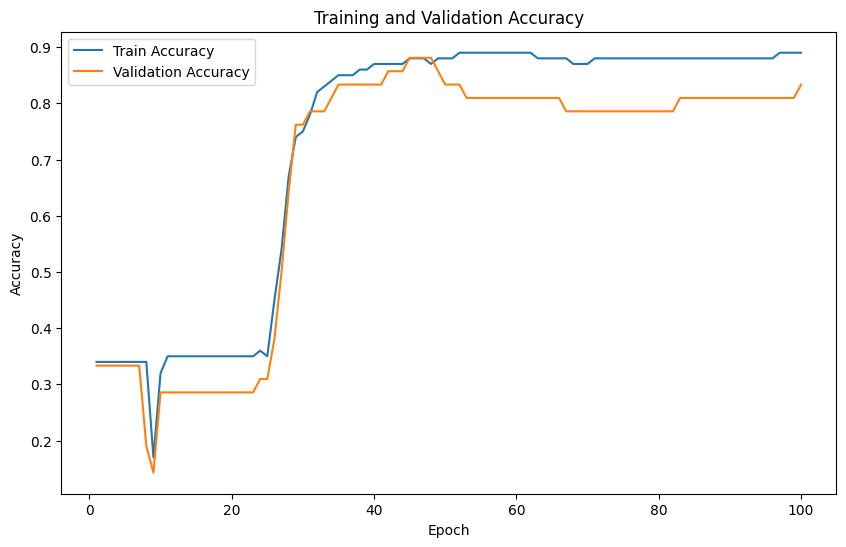

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Chọn epoch=60

In [59]:
all_test_labels, all_test_preds = [], []

model = Net(input_dim, hidden_dim, output_dim).to(device)

selected_epoch = 60
model.load_state_dict(torch.load(f'weights_epoch_{selected_epoch}.pth'))

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)

        all_test_labels.extend(y.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())

# Generate classification report
print(classification_report(all_test_labels, all_test_preds, target_names= iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         3
  versicolor       1.00      0.67      0.80         3
   virginica       0.67      1.00      0.80         2

    accuracy                           0.88         8
   macro avg       0.89      0.89      0.87         8
weighted avg       0.92      0.88      0.88         8



<ipython-input-59-89393f490889>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights_epoch_{selected_epoch}.pth'))
